In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import os.path
import requests
import tensorflow as tf
from tensorflow import keras

sys.path.append("../01_crop_image")
from get_clean_image import *

import sys
sys.path.append("../02_extract_digits")
from get_digits import *

In [2]:
if True or "필요시":
    config = tf.compat.v1.ConfigProto(gpu_options = 
                             tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
    )
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

In [3]:
image_width = 28
image_height = 28
model = tf.keras.models.load_model('../05_apply_MNIST/model')

s=0

def alarm(msg, channel):
    if channel[0] == 'X': return

    payload = {'text': msg}
    r = requests.post(channel, json=payload)
    print(r.text, msg, channel)

def doit(number, digit5):
    global s
    slack = 'XXhttps://hooks.slack.com/services/T017L20056V/B01JDDMUUJY/PUT YOUR SLACK HOOKUP'
    try:
        with open("meter.current", "r") as f: value = int(f.read())
    except:
        with open("meter.current", "w") as f: f.write(str(number))
        value = number

    print('doit',number,',',value, digit5)

    if number == value:
        #alarm("same meter reading %d.%s"%(number,digit5), slack)
        print("same meter reading %d.%s"%(number,digit5))

        url2 = 'http://54.180.106.144:8080/meter/%d.%s'%(number, digit5[0])
        print(url2)
        r = requests.get(url2)
       #print('push to digital_twim', r.text)

        s+=1
    elif number == value+1:
        with open("meter.current", "w") as f: f.write(str(number))

        url2 = 'http://54.180.106.144:8080/meter/%d.%s'%(number,digit5[0])
        print(url2)
        r = requests.get(url2)
        print('push to digital_twim', r.text)


        alarm("meter +1 ok %d.%s"%(number,digit5), slack)
        print("meter +1 ok %d.%s"%(number,digit5))
        s+=1
    else:
        print("Meter wrong %d.%s"%(number,digit5))
        alarm("Meter wrong %d.%s"%(number,digit5), slack)


2824
doit 282 , 282 4
same meter reading 282.4
http://54.180.106.144:8080/meter/282.4


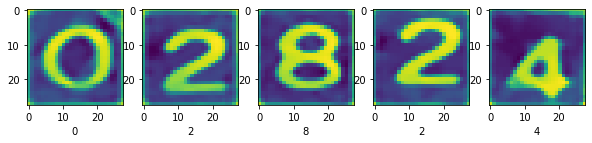

In [4]:
def run_a_cycle(cmd):
    global img, img1
    img = url_to_image('http://54.180.106.144:8080/websensor')
    img = rotate_image(img)
    img = fix_persepective(img)
    img = crop_image(img)
    img = cv2.medianBlur(img,9)
    
    rois = to_digit_images(img)
    n = 0
    if cmd == "show": plt.figure(figsize=(10,3))
    for i, img1 in enumerate(rois):
        img1 = cv2.resize(img1, (image_width, image_height), interpolation = cv2.INTER_AREA)
        img1 = np.expand_dims(img1,0)/255.
      
        prediction = model.predict(img1)
        ans = np.argmax(prediction[0])
        if cmd == "show":
            plt.subplot(1,5,i+1)
            plt.imshow(img1[0])
            plt.xlabel(ans)
        n = n*10 + ans
    print(n)
    doit(int(n/10), ("%d"%n)[-1])
    plt.show()

if __name__ == "__main__":
    run_a_cycle("show")